### Social Network Project:

#### Data
 - We have an existing social network graph. We have nodes which are linked to each other in the graph via edges, representing friendship linkages. 
 - Every node represents a real world person in a University campus. Thus, he/she has some real world profile attributes like Year of Study, Dorm of Stay, Major of Study, Relationship Status, etc. 
 - The aim of our project is to analyse and improve a simple recommendation algorithm. The algorithm helps people connect over to each other on the campus. It goes as follows: Suppose we have a person A, a friend B is randomly chosen. A friend of B, C is again randomly chosen and recommended to A as a friend. A acts as a base user (also referred to as Profile), B acts a friend and C acts as a Friend of Friend (FoF).
 - Upon receiving such a recommendation, the base user, A can either ignore or attend and send FoF, C a friend request.
 - C can either accept (be friends of A in the graph, establish a link), or reject the request. 
 - For every user in the graph the dataset (Observations.csv file) contains Profile-Friend-FoF, whether the recommendation was sent and whether it was accepted (if sent). The overall dataset is highly imbalanced, which needs to be taken into account. 
 - The Networks.csv file consists of network links in the graph (existing), and the Profiles.csv table contains the profile features of every person in the network.
 - The encodings are in string form of hash codes. This is ensure privacy of the concerned person whose information is being used.
 - We need to design supervised machine learning models which will analyse the efficiency of the recommendation algorithm and try to suggest some simple imrpovements by deriving insights. We also try to devise some new features, which can help improve the prediction. 

#### Agenda

- The data at hand is of a social network. 
- Extract the features and the class labels.
- Do markov clustering to cluster the graph. Assign automated cluster IDs.
- Categorical featrues to be one hot encoded. Do both standardization and Normalization and check the results.
- Train linear classifiers, decision trees, SVMs, Random forests. Choose best hyper-parameters  y cross-validation
- Check accuracy and f1-score on test dataset, being aware of class imbalance. 
- Do some analysis of friend requests across different genders.


- Steps:
 - Loading data and pre-processing
 - Extracting graph based features
 - Extracting qualitative features
 - Choosing a model to train
 - Optimizing hyper-parameters by k-fold CV
 - Interpreting the results
 - Accessing performance on imbalanced classes

#### Graph features  

- Cluster ID: Equivalence feature. Every pair (Profile-Friend, Friend-FoF, FoF-Profile) has a boolean feature. Value is 1 if both the entities in the pair belong to the same cluster, else it's 0.
- Pagerank: Absolute feature. Every tuple (Profile, Friend, FoF) will have an elementwise pagerank value. Pagerank signifies the centrality of a node. 
- Friend Sharing Likelihood: Absolute feature. A measure of number of neighbors which are neighbors themselves. Normalized by maximum value in order to maintain numeric consistency. 
- Degree: Absolute feature. Degree represents connectivity of a node. 
- Common friends: Equivalence feature. Every pair (Profile-Friend, Friend-FoF, FoF-Profile) has a numeric valued feature. For example, we count the number of common friends between Profile & Friend. Then normalize by sum of friends of Profile & Friend. This ensures value between 0-1 and is consistent. This is a new feature which we added after some deliberation. 

#### Profile Features:

- Dorm & Major: Equivalence Boolean features for every pair of (Profile-Friend, Friend-FoF, FoF-Profile).
- Year, Sex, Relationship status: Absolute feature for each node. 



In [553]:
# import warnings
# warnings.filterwarnings('ignore')

In [554]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import markov_clustering as mc
import itertools
from funcy import join
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from collections import ChainMap
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [555]:
def load_preprocess(path):
    path_0,path_1,path_2 = path
    df_profiles = pd.read_csv(path_0)
    df_observations = pd.read_csv(path_1)
    df_friendships = pd.read_csv(path_2)       # The 3 tables loaded into dataframes 
    
    print("Working with the Tables...\n")
    print("Columns containing NULL values...\n")
    
    # describe to find out the NULL values: 
    df_profiles_desc = df_profiles.describe().T
    df_observations_desc = df_observations.describe().T
    df_friendships_desc = df_friendships.describe().T
    
    # primary key : Max count value: Assume atleast one primary key exists
    print("\nThe columns which consist of NULL values in profiles table are:\n")
    count_max = df_profiles_desc['count'].max()
    print((df_profiles_desc[df_profiles_desc['count']!=count_max]))
    
    print("\nThe columns which consist of NULL values in friendships table are:\n")
    count_max = df_friendships_desc['count'].max()
    print((df_friendships_desc[df_friendships_desc['count']!=count_max]))
    
    print("\nThe columns which consist of NULL values in observations table are:\n")
    count_max = df_observations_desc['count'].max()
    print((df_observations_desc[df_observations_desc['count']!=count_max]))
    
    print("\nObservations (class labels) and Friendships (graph linkages) do not contain NULL values in any columns\n")
    
    
    print("\nReplacing NULL values in these columns...\n")
    df_profiles.fillna(0,inplace=True)
    
#     print(df_profiles.columns)
    
    # Equivalence features need not be one-hot encoded, they are just compared and 0/1 features are generated


    # One hot encoding did not provide any additional advantage: hence we go with simple numeric conversion of categorical labels

    print("\nConverting other categorical labels to numeric values...\n")
    
    
    df_profiles[['Dorm','Major','Relationship_Status','Sex','Year']] = df_profiles[['Dorm','Major','Relationship_Status','Sex','Year']].astype('category')
    df_profiles['Dorm'] = df_profiles['Dorm'].cat.codes
    df_profiles['Major'] = df_profiles['Major'].cat.codes
    df_profiles['Relationship_Status'] = df_profiles['Relationship_Status'].cat.codes
    df_profiles['Sex'] = df_profiles['Sex'].cat.codes
    df_profiles['Year'] = df_profiles['Year'].cat.codes
#     print(df_profiles.head())
    

    df_profiles['Profile_ID_numeric'] = df_profiles.index.values       # Profile ID column numeric mapping 
    profile_to_numeric_df = df_profiles[['Profile_ID','Profile_ID_numeric']]        # Keep separate for ease of use 
    df_profiles = df_profiles.drop(columns='Profile_ID_numeric')
    
    print("\n\n\n\n")

    print(df_profiles)

    print(df_observations)
    print(df_friendships)
    print(profile_to_numeric_df)
    
# Our dataframes are ready for futher analysis 

    
    return df_profiles,df_observations,df_friendships,profile_to_numeric_df #,df_profile_numeric_dict,df_profile_numeric_dict_reverse
    
    
    
df_profiles,df_observations,df_friendships,profile_to_numeric_df = load_preprocess(['friendhook/Profiles.csv','friendhook/Observations.csv','friendhook/Friendships.csv'])

Working with the Tables...

Columns containing NULL values...


The columns which consist of NULL values in profiles table are:

                    count unique           top  freq
Relationship_Status  3631      3  ac0b88e46e20  1963

The columns which consist of NULL values in friendships table are:

Empty DataFrame
Columns: [count, unique, top, freq]
Index: []

The columns which consist of NULL values in observations table are:

Empty DataFrame
Columns: [count, unique, top, freq]
Index: []

Observations (class labels) and Friendships (graph linkages) do not contain NULL values in any columns


Replacing NULL values in these columns...


One hot encoding categorical features for Absolute columns ...


Converting other categorical labels to numeric values...






        Profile_ID  Sex  Relationship_Status  Dorm  Major  Year
0     b8bc075e54b9    0                    2     5     13     2
1     49194b3720b6    0                    3    12      6     1
2     f0f5962bbc52    0         

In [556]:
def construct_features_class_labels(df_profiles,df_observations,df_friendships,profile_to_numeric_df):
    """Construct class labels and features and append everything to a single data-frame"""
    # constructing class labels: 3 classes: 0,1,2
    df_observations['class_label'] = df_observations['Friend_Request_Sent']*2-df_observations['Friend_Request_Accepted']
    df_observations = df_observations.merge(profile_to_numeric_df, left_on='Profile_ID', right_on='Profile_ID',how="left")
    df_observations = df_observations.merge(profile_to_numeric_df, left_on='Selected_Friend', right_on='Profile_ID',how="left")

    df_observations = df_observations.merge(profile_to_numeric_df, left_on='Selected_Friend_of_Friend', right_on='Profile_ID',how="left")
    
    df_observations = df_observations.drop(columns=['Profile_ID_y', 'Profile_ID'])
    df_observations = df_observations.rename(columns={"Selected_Friend":"Friend",
                                                      "Selected_Friend_of_Friend":"FoF",
                                                      "Friend_Request_Sent":"Sent",
                                                      "Friend_Request_Accepted":"Accepted",
                                                      "Profile_ID_x": "Profile_ID",
                                                    "Profile_ID_numeric_x": "Profile_ID_numeric", 
                                                    "Profile_ID_numeric_y": "Friend_numeric",
                                                   "Profile_ID_numeric": "FoF_numeric"})
    
    
    
    
    df_friendships = df_friendships.merge(profile_to_numeric_df,left_on='Friend_A',right_on='Profile_ID',how="left")
    df_friendships = df_friendships.merge(profile_to_numeric_df,left_on='Friend_B',right_on='Profile_ID',how="left")
    df_friendships = df_friendships.drop(columns=['Profile_ID_x', 'Profile_ID_y'])
    df_friendships = df_friendships.rename(columns={"Profile_ID_numeric_x": "Friend_A_numeric", "Profile_ID_numeric_y": "Friend_B_numeric"})
    
    # Constructing graph based features:
    
    # construct a network graph and add the edges from the friendship linkages file
    G = nx.Graph() 
    edge_links = []  
#     print(df_friendships[['Friend_A_numeric','Friend_B_numeric']].values)
    for id1,id2,n1,n2 in (df_friendships[['Friend_A','Friend_B','Friend_A_numeric','Friend_B_numeric']].values):
        edge_links.append((id1,id2))
        G.add_edge(n1,n2) 
        
    node_list = list(G.nodes)        # This node list is extremely important, later clusters will output the index values belonging to 
    # each of the cluster: This node list helps procure the nodes from those index values 

    print("\nConstructing the social graph...\n")

    num_nodes = len(node_list)
    print(f"The social graph contains {num_nodes} nodes.")


    
    # Constructing network based features:
    # All the features will be deposited in the observations table (Network and Profile features)
    # From there on we can choose which features we want to keep to train our model
    
    # degree:
#     print(*G.degree(df_observations['Profile_ID_numeric']))
    df_observations['Profile_ID_degree'] = list(zip(*G.degree(df_observations['Profile_ID_numeric'])))[1]
    # dictionary preserves order by default in newer versions of python
    df_observations['Friend_degree'] = list(zip(*G.degree(df_observations['Friend_numeric'])))[1]
    df_observations['FoF_degree'] = list(zip(*G.degree(df_observations['FoF_numeric'])))[1]

    
    # cluster-id:
    matrix = nx.to_scipy_sparse_matrix(G)         # sparse adjacency matrix of the graph 
    result = mc.run_mcl(matrix)       
    clusters = mc.get_clusters(result) 
    num_clusters = len(clusters)
    cluster_dict = dict(zip((clusters),range(len(clusters))))      # Now this dict should be used to add the cluster IDs
    cluster_dict = {node_list[k_i]:v for k, v in cluster_dict.items() for k_i in k} # Because index is returned by the clustering algorithm
      
    cluster_df = pd.DataFrame(cluster_dict,index=['Cluster_ID']).T
    cluster_df = cluster_df.reset_index()
    cluster_df = cluster_df.rename(columns={'index': 'Profile_ID_numeric'})

    df_observations = df_observations.merge(cluster_df, left_on='Profile_ID_numeric', right_on='Profile_ID_numeric',how="left")

    df_observations = df_observations.merge(cluster_df, left_on='Friend_numeric', right_on='Profile_ID_numeric',how="left")

    df_observations = df_observations.merge(cluster_df, left_on='FoF_numeric', right_on='Profile_ID_numeric',how="left")

    
    df_observations = df_observations.drop(columns=['Profile_ID_numeric_y', 'Profile_ID_numeric'])
    
    df_observations = df_observations.rename(columns={
                                                      "Profile_ID_numeric_x": "Profile_ID_numeric",
        "Cluster_ID_x":"Profile_ID_Cluster","Cluster_ID_y":"Friend_Cluster","Cluster_ID":"FoF_Cluster"
                                                   })

    
#     # pagerank:
    node_to_pagerank = nx.pagerank(G)      # Direct node numeric value can be entered here 
    pagerank_df = pd.DataFrame(node_to_pagerank,index=['Pagerank']).T
    pagerank_df = pagerank_df.reset_index()
    pagerank_df = pagerank_df.rename(columns={'index': 'Profile_ID_numeric'})
#     print(pagerank_df)



    df_observations = df_observations.merge(pagerank_df, left_on='Profile_ID_numeric', right_on='Profile_ID_numeric',how="left")
    df_observations = df_observations.merge(pagerank_df, left_on='Friend_numeric', right_on='Profile_ID_numeric',how="left")
    df_observations = df_observations.merge(pagerank_df, left_on='FoF_numeric', right_on='Profile_ID_numeric',how="left")
    
    df_observations = df_observations.drop(columns=['Profile_ID_numeric_y', 'Profile_ID_numeric'])
    
    df_observations = df_observations.rename(columns={
                                                      "Profile_ID_numeric_x": "Profile_ID_numeric",
        "Pagerank_x":"Profile_ID_Pagerank","Pagerank_y":"Friend_Pagerank","Pagerank":"FoF_Pagerank"
                                                   })
    
#     # friend-sharing-likelihood


    d = defaultdict(list)
    # List of tuples: 1st element is the node and 2nd element is a list of neighbors 
    adjacent_nodes = list(zip(df_observations['Profile_ID_numeric'].values,list(map(list,map(G.neighbors, df_observations['Profile_ID_numeric'].values)))))
    adjacency_dict = dict(adjacent_nodes)
    
    func = lambda x: tuple(itertools.product([d],[G],[x[0]], x[1]))   # all possible combinations 
    # All possible combinations of the dict, graph, and the neighbors 
    adjacency_tuples = list(map(func,adjacent_nodes))
    # Just unpack the above list of tuples 
    adjacency_tuples = list(itertools.chain(*adjacency_tuples))
    
    
    # common neighbors takes in 3 arguments: graph G, u and v two nodes in the graph returns the set of common neighbors (nodeS)
    common_neighbors_length = lambda x: x[0][x[2]].append(len(list(nx.common_neighbors(x[1],x[2],x[3]))))

    temp = list(map(common_neighbors_length,adjacency_tuples))
    
    k=dict(d)
    p=list(k.items())
    friend_sharing_compute = lambda k: (k[0],sum(k[1])/((len(k[1]))*(len(k[1])-1))) if ((len(k[1]))*(len(k[1])-1)) else (k[0],0)
    friend_sharing_likelihood = dict(map(friend_sharing_compute,p))
    # now convert it to a dataframe
    friend_sharing_df = pd.DataFrame(friend_sharing_likelihood,index=['f_s_likelihood']).T
    friend_sharing_df = friend_sharing_df.reset_index()
    friend_sharing_df = friend_sharing_df.rename(columns={'index': 'Profile_ID_numeric'})
    
    df_observations = df_observations.merge(friend_sharing_df, left_on='Profile_ID_numeric', right_on='Profile_ID_numeric',how="left")
    df_observations = df_observations.merge(friend_sharing_df, left_on='Friend_numeric', right_on='Profile_ID_numeric',how="left")
    df_observations = df_observations.merge(friend_sharing_df, left_on='FoF_numeric', right_on='Profile_ID_numeric',how="left")
    
    df_observations = df_observations.drop(columns=['Profile_ID_numeric_y', 'Profile_ID_numeric'])
    
    df_observations = df_observations.rename(columns={
                                                      "Profile_ID_numeric_x": "Profile_ID_numeric",
        "f_s_likelihood_x":"Profile_ID_likelihood","f_s_likelihood_y":"Friend_likelihood","f_s_likelihood":"FoF_likelihood"})

    # Number of common friends: 
    # Say we have the Profile_ID and FoF columns : Find the common friends amongst the two and divide by total number of friends 
    
    common_friends_function = lambda x: len(list(nx.common_neighbors(G,x[0],x[1])))/(len(adjacency_dict[x[0]])+len(adjacency_dict[x[1]]))

    profile_friend_tuples = df_observations[['Profile_ID_numeric','Friend_numeric']].values
    common_friends_profile_friend = list(map(common_friends_function,profile_friend_tuples))
    df_observations['Profile_ID_Friend_commonfriends'] = common_friends_profile_friend
    
    
    
    profile_fof_tuples = df_observations[['Profile_ID_numeric','FoF_numeric']].values
    common_friends_profile_fof = list(map(common_friends_function,profile_fof_tuples))
    df_observations['Profile_ID_FoF_commonfriends'] = common_friends_profile_fof
    
    
    
    fof_friend_tuples = df_observations[['FoF_numeric','Friend_numeric']].values
    common_friends_fof_friend = list(map(common_friends_function,fof_friend_tuples))
    df_observations['FoF_Friend_commonfriends'] = common_friends_fof_friend
    
    
    # Now add profile features:
    
    df_observations = df_observations.merge(df_profiles, left_on='Profile_ID', right_on='Profile_ID',how="left")
    df_observations = df_observations.merge(df_profiles, left_on='Friend', right_on='Profile_ID',how="left")
    df_observations = df_observations.merge(df_profiles, left_on='FoF', right_on='Profile_ID',how="left")
    
    df_observations = df_observations.drop(columns=['Profile_ID_y', 'Profile_ID'])
    df_observations = df_observations.rename(columns={"Profile_ID_x": "Profile_ID"})
    
    x_cols = list(df_observations.columns[df_observations.columns.str.contains(pat = '_x')])
    y_cols = list(df_observations.columns[df_observations.columns.str.contains(pat = '_y')])
    
    
    x_cols_string_add = ["Profile_"]*len(x_cols)
    y_cols_string_add = ["Friend_"]*len(y_cols)
    orig_cols_string_add = ["FoF_"]*len(x_cols)
    
    string_add_lambda = lambda k,lis: k+lis[:-2]
    
    x_cols_dict = dict(list(zip(x_cols,list(map(string_add_lambda,x_cols_string_add,x_cols)))))
    y_cols_dict = dict(list(zip(y_cols,list(map(string_add_lambda,y_cols_string_add,y_cols)))))
    orig_cols_dict = dict(list(zip(list(map(lambda k:k[:-2],x_cols)),list(map(string_add_lambda,orig_cols_string_add,x_cols)))))
    
#     print(x_cols_dict)
    df_observations = df_observations.rename(columns=x_cols_dict)
    df_observations = df_observations.rename(columns=y_cols_dict)
    df_observations = df_observations.rename(columns=orig_cols_dict)
    

    print(df_profiles)
    
    
    print(df_observations)
    
    print(df_friendships)
    
    return df_profiles,df_observations,df_friendships

# 
    
df_profiles,df_observations,df_friendships = construct_features_class_labels(df_profiles,df_observations,df_friendships,profile_to_numeric_df)   


Constructing the social graph...

The social graph contains 4039 nodes.
        Profile_ID  Sex  Relationship_Status  Dorm  Major  Year
0     b8bc075e54b9    0                    2     5     13     2
1     49194b3720b6    0                    3    12      6     1
2     f0f5962bbc52    0                    3    12     29     2
3     d42f06d92a52    0                    3     4     25     0
4     81123b29ee66    1                    2    12      2     0
...            ...  ...                  ...   ...    ...   ...
4034  78e200cb274d    0                    3    12     11     1
4035  632877112b08    1                    2    12      2     0
4036  2fcb9e82642e    0                    3    12     11     1
4037  8ab2149b48e9    1                    3    12     11     1
4038  cb4be25afda7    0                    2     4     26     1

[4039 rows x 6 columns]
        Profile_ID        Friend           FoF   Sent  Accepted  class_label  \
0     9e5bec3ed583  b8bc075e54b9  b5e368c3f830  False 

In [557]:
def choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set,profile_feats,method):
    """Choose all or a particular few features, do standardization/normalization, assign labels"""
    df_observations = df_observations.filter(regex='|'.join(feature_set)+'|class_label')

    if not profile_feats:           # only network features here : Only the Cluster (cluster_id) attribute is relative (equivalence)
        if("Cluster" in feature_set):     # 
            df_observations = df_observations.assign(Profile_Friend_Cluster=np.where((df_observations['Profile_ID_Cluster']==df_observations['Friend_Cluster']),1,0))
            df_observations = df_observations.assign(Friend_FoF_Cluster=np.where((df_observations['FoF_Cluster']==df_observations['Friend_Cluster']),1,0))
            df_observations = df_observations.assign(FoF_Profile_Cluster=np.where((df_observations['Profile_ID_Cluster']==df_observations['FoF_Cluster']),1,0))
            df_observations = df_observations.drop(columns=['Profile_ID_Cluster', 'Friend_Cluster', 'FoF_Cluster'])
        y = df_observations['class_label'].values
        df_observations = df_observations.drop(columns=['class_label'])
        X = df_observations.values

    else:         # some profile features are also present 
        if("Dorm" in feature_set):
            df_observations = df_observations.assign(Profile_Friend_Dorm=np.where((df_observations['Profile_Dorm']==df_observations['Friend_Dorm']),1,0))
            df_observations = df_observations.assign(Friend_FoF_Dorm=np.where((df_observations['FoF_Dorm']==df_observations['Friend_Dorm']),1,0))
            df_observations = df_observations.assign(FoF_Profile_Dorm=np.where((df_observations['Profile_Dorm']==df_observations['FoF_Dorm']),1,0))

            df_observations = df_observations.drop(columns=['Profile_Dorm', 'Friend_Dorm', 'FoF_Dorm'])
            
        if("Major" in feature_set):
            df_observations = df_observations.assign(Profile_Friend_Major=np.where((df_observations['Profile_Major']==df_observations['Friend_Major']),1,0))
            df_observations = df_observations.assign(Friend_FoF_Major=np.where((df_observations['FoF_Major']==df_observations['Friend_Major']),1,0))
            df_observations = df_observations.assign(FoF_Profile_Major=np.where((df_observations['Profile_Major']==df_observations['FoF_Major']),1,0))

            df_observations = df_observations.drop(columns=['Profile_Major', 'Friend_Major', 'FoF_Major'])
            
        if("Cluster" in feature_set):     # 
            df_observations = df_observations.assign(Profile_Friend_Cluster=np.where((df_observations['Profile_ID_Cluster']==df_observations['Friend_Cluster']),1,0))
            df_observations = df_observations.assign(Friend_FoF_Cluster=np.where((df_observations['FoF_Cluster']==df_observations['Friend_Cluster']),1,0))
            df_observations = df_observations.assign(FoF_Profile_Cluster=np.where((df_observations['Profile_ID_Cluster']==df_observations['FoF_Cluster']),1,0))
            
            df_observations = df_observations.drop(columns=['Profile_ID_Cluster', 'Friend_Cluster', 'FoF_Cluster'])
        y = df_observations['class_label'].values
        df_observations = df_observations.drop(columns=['class_label'])

        X = df_observations.values

    print(df_observations.columns)    
    feat_list = df_observations.columns.values 

        
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
    
    if(method=="std"): # standardize the features 
        scaler = StandardScaler()
        temp = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    elif(method=="norm"):  # normalize the features 
        norm_func = Normalizer()
        temp = norm_func.fit(X_train)
        X_train = norm_func.transform(X_train)
        X_test = norm_func.transform(X_test)        
        # return the raw features as they are 
        
    feat_list = df_observations.columns.values  

    return X_train, X_test, y_train, y_test, feat_list

# Be cautious about case-sensitivity 
X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="None")


Index(['Profile_ID_degree', 'Friend_degree', 'FoF_degree',
       'Profile_ID_Pagerank', 'Friend_Pagerank', 'FoF_Pagerank',
       'Profile_ID_likelihood', 'Friend_likelihood', 'FoF_likelihood',
       'Profile_ID_Friend_commonfriends', 'Profile_ID_FoF_commonfriends',
       'FoF_Friend_commonfriends', 'Profile_Sex',
       'Profile_Relationship_Status', 'Profile_Year', 'Friend_Sex',
       'Friend_Relationship_Status', 'Friend_Year', 'FoF_Sex',
       'FoF_Relationship_Status', 'FoF_Year', 'Profile_Friend_Dorm',
       'Friend_FoF_Dorm', 'FoF_Profile_Dorm', 'Profile_Friend_Major',
       'Friend_FoF_Major', 'FoF_Profile_Major', 'Profile_Friend_Cluster',
       'Friend_FoF_Cluster', 'FoF_Profile_Cluster'],
      dtype='object')


In [1]:
# Training a decision tree classifier (after cross validation gridsearch CV)
# The hyperparameters optimized are: max_depth, min_samples_split, min_samples_leaf, ccp_alpha (pruning parameter)


def train_test_decision_tree_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list):
    """ The hyper-parameter tuning is carried out using a weighted f1-score """
    np.random.seed(0)
    print("train_test_decision_tree_unweighted_classifier")

    hyperparams = {'max_depth': list(range(3, 25)),'min_samples_split': list(range(2, 100)),'min_samples_leaf': list(range(1, 25)),
                   'max_features': list(range(3, len(feat_list)))
                   +
                   [None]}

    
    clf_grid = GridSearchCV(DecisionTreeClassifier(), hyperparams, 
                            scoring='f1_macro', cv=5)         # Ther overall dataset is imbalanced, hence we are using f1-score as our metric
    clf_grid.fit(X_train, y_train)
    best_f = clf_grid.best_score_
    
    parameter_dict = clf_grid.best_params_
    
    np.random.seed(0)
    # 7,6,6,16
    # 6,24,9,19

    clf = DecisionTreeClassifier(max_depth=clf_grid.best_params_['max_depth'],min_samples_split=clf_grid.best_params_['min_samples_split'],
                                 min_samples_leaf=clf_grid.best_params_['min_samples_leaf'],max_features=clf_grid.best_params_['max_features'])


    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f_measure_macro = round(f1_score(pred, y_test, average='macro'),2)
    f_measure_weighted = round(f1_score(pred, y_test, average='weighted'),2)

    accuracy = accuracy_score(pred, y_test)

    top = 5
    feat_dict = {}
    for i in np.argsort(clf.feature_importances_)[::-1]:
        if(round(clf.feature_importances_[i],2)!=0 and top>=0):
#             print(f"{feat_list[i]} : {clf.feature_importances_[i]:0.2f}")
            feat_dict[feat_list[i]] = round(clf.feature_importances_[i],2)
            top-=1
#     print("\n Printing the trained Tree\n")        
#     text_tree = tree.export_text(clf, feature_names=list(feat_list))
#     print(text_tree)
    
    return f_measure_macro,f_measure_weighted,round(100*accuracy,2),np.around(f1_score(pred, y_test,average=None),2),feat_dict           
       
print(train_test_decision_tree_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list))



In [2]:
def train_test_decision_tree_weighted_classifier(X_train, X_test, y_train, y_test, feat_list):
    """ The hyper-parameter tuning is carried out using a weighted f1-score """
    np.random.seed(0)
    print("train_test_decision_tree_weighted_classifier")

    hyperparams = {'max_depth': list(range(3, 25)),'min_samples_split': list(range(2, 100)),'min_samples_leaf': list(range(1, 25)),
                   'max_features': list(range(3, len(feat_list)))+
                   [None]}

    
    clf_grid = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), hyperparams, 
                            scoring='f1_weighted', cv=5)         # Ther overall dataset is imbalanced, hence we are using f1-score as our metric
    clf_grid.fit(X_train, y_train)
    best_f = clf_grid.best_score_
 
    parameter_dict = clf_grid.best_params_
    
    np.random.seed(0)
    # 7,6,6,16
    # 6,24,9,19

    clf = DecisionTreeClassifier(max_depth=clf_grid.best_params_['max_depth'],min_samples_split=clf_grid.best_params_['min_samples_split'],
                                 min_samples_leaf=clf_grid.best_params_['min_samples_leaf'],max_features=clf_grid.best_params_['max_features'],
                                class_weight='balanced')



    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f_measure_macro = round(f1_score(pred, y_test, average='macro'),2)
    f_measure_weighted = round(f1_score(pred, y_test, average='weighted'),2)

    accuracy = accuracy_score(pred, y_test)


    top = 5
    feat_dict = {}
    for i in np.argsort(abs(clf.feature_importances_))[::-1]:
        if(round(clf.feature_importances_[i],2)!=0 and top>=0):
#             print(f"{feat_list[i]} : {clf.feature_importances_[i]:0.2f}")
            feat_dict[feat_list[i]] = round(clf.feature_importances_[i],2)
            top-=1
    print("\n Printing the trained WEighted Decision Tree\n")     
    text_tree = tree.export_text(clf, 
                             feature_names=list(feat_list))
    print(text_tree)
    
    
    return f_measure_macro,f_measure_weighted,round(100*accuracy,2),np.around(f1_score(pred, y_test,average=None),2),feat_dict          
       
print(train_test_decision_tree_weighted_classifier(X_train, X_test, y_train, y_test, feat_list))


In [3]:
def train_test_random_forest_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list):
    
    # choose the best hyper-parameters and then train a random forest classifier:
    np.random.seed(0)
    print("train_test_random_forest_unweighted_classifier")
# max_depth=5,n_estimators=40,max_features=30,min_samples_split=2,min_samples_leaf=1

    hyperparams = {'max_depth': list(range(3, 25)),'min_samples_split': list(range(2, 100)),'min_samples_leaf': list(range(1, 25)),
                   'max_features': list(range(3, len(feat_list))),'n_estimators':list(range(2,50))+
                   [None]}

    
    clf_grid = GridSearchCV(RandomForestClassifier(), hyperparams, 
                            scoring='f1_macro', cv=5)         # Ther overall dataset is imbalanced, hence we are using f1-score as our metric
    clf_grid.fit(X_train, y_train)
    best_f = clf_grid.best_score_

    parameter_dict = clf_grid.best_params_
    
    np.random.seed(0)
    # 7,6,6,16
    # 6,24,9,19
    clf = RandomForestClassifier(max_depth=clf_grid.best_params_['max_depth'],n_estimators=clf_grid.best_params_['n_estimators'], min_samples_split=clf_grid.best_params_['min_samples_split'],
                                 min_samples_leaf=clf_grid.best_params_['min_samples_leaf'],max_features=clf_grid.best_params_['max_features'])
    


    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f_measure_macro = round(f1_score(pred, y_test, average='macro'),2)
    f_measure_weighted = round(f1_score(pred, y_test, average='weighted'),2)
    
    accuracy = accuracy_score(pred, y_test)

    top = 5
    feat_dict = {}
    for i in np.argsort(clf.feature_importances_)[::-1]:
        if(round(clf.feature_importances_[i],2)!=0 and top>=0):
#             print(f"{feat_list[i]} : {clf.feature_importances_[i]:0.2f}")
            feat_dict[feat_list[i]] = round(clf.feature_importances_[i],2)
            top-=1


    return f_measure_macro,f_measure_weighted,round(100*accuracy,2),np.around(f1_score(pred, y_test,average=None),2),feat_dict
    
print(train_test_random_forest_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list))
    

    

In [4]:
def train_test_random_forest_weighted_classifier(X_train, X_test, y_train, y_test, feat_list):
    
    # choose the best hyper-parameters and then train a random forest classifier:
    np.random.seed(0)
    print("train_test_random_forest_weighted_classifier")
# max_depth=5,n_estimators=40,max_features=30,min_samples_split=2,min_samples_leaf=1

    hyperparams = {'max_depth': list(range(3, 25)),'min_samples_split': list(range(2, 100)),'min_samples_leaf': list(range(1, 25)),
                   'max_features': list(range(3, len(feat_list))),'n_estimators':list(range(2,50))+
                   [None]}

    
    clf_grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), hyperparams, 
                            scoring='f1_weighted', cv=5)         # Ther overall dataset is imbalanced, hence we are using f1-score as our metric
    clf_grid.fit(X_train, y_train)
    best_f = clf_grid.best_score_


    parameter_dict = clf_grid.best_params_
    
    np.random.seed(0)
    # 7,6,6,16
    # 6,24,9,19

    
    clf = RandomForestClassifier(max_depth=clf_grid.best_params_['max_depth'],n_estimators=clf_grid.best_params_['n_estimators'],
                             min_samples_split=clf_grid.best_params_['min_samples_split'],
                             min_samples_leaf=clf_grid.best_params_['min_samples_leaf'],max_features=clf_grid.best_params_['max_features'],
                            class_weight='balanced')

    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f_measure_macro = round(f1_score(pred, y_test, average='macro'),2)
    f_measure_weighted = round(f1_score(pred, y_test, average='weighted'),2)
    
    accuracy = accuracy_score(pred, y_test)

    top = 5
    feat_dict = {}
    for i in np.argsort(abs(clf.feature_importances_))[::-1]:
        if(round(clf.feature_importances_[i],2)!=0 and top>=0):
#             print(f"{feat_list[i]} : {clf.feature_importances_[i]:0.2f}")
            feat_dict[feat_list[i]] = round(clf.feature_importances_[i],2)
            top-=1


    return f_measure_macro,f_measure_weighted,round(100*accuracy,2),np.around(f1_score(pred, y_test,average=None),2),feat_dict
    
print(train_test_random_forest_weighted_classifier(X_train, X_test, y_train, y_test, feat_list))
    

    


In [562]:
# Logistic Regression Classifier  Hyper-parameter tuning:
def train_test_logistic_regression_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list):
    np.random.seed(0)
    print("train_test_logistic_regression_unweighted_classifier")
    clf = LogisticRegression(C=3,solver='lbfgs',max_iter=10000)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    f_measure_macro = round(f1_score(pred, y_test, average='macro'),2)
    f_measure_weighted = round(f1_score(pred, y_test, average='weighted'),2)
    
    accuracy = accuracy_score(pred, y_test)
#     print(f"{f_measure_macro:0.2f},{accuracy:0.2f}")
    feat_dict = {}
    return f_measure_macro,f_measure_weighted,round(100*accuracy,2),np.around(f1_score(pred, y_test,average=None),2),feat_dict


X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="std")
# X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="none")


print(train_test_logistic_regression_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list))    

Index(['Profile_ID_degree', 'Friend_degree', 'FoF_degree',
       'Profile_ID_Pagerank', 'Friend_Pagerank', 'FoF_Pagerank',
       'Profile_ID_likelihood', 'Friend_likelihood', 'FoF_likelihood',
       'Profile_ID_Friend_commonfriends', 'Profile_ID_FoF_commonfriends',
       'FoF_Friend_commonfriends', 'Profile_Sex',
       'Profile_Relationship_Status', 'Profile_Year', 'Friend_Sex',
       'Friend_Relationship_Status', 'Friend_Year', 'FoF_Sex',
       'FoF_Relationship_Status', 'FoF_Year', 'Profile_Friend_Dorm',
       'Friend_FoF_Dorm', 'FoF_Profile_Dorm', 'Profile_Friend_Major',
       'Friend_FoF_Major', 'FoF_Profile_Major', 'Profile_Friend_Cluster',
       'Friend_FoF_Cluster', 'FoF_Profile_Cluster'],
      dtype='object')
train_test_logistic_regression_unweighted_classifier
(0.84, 0.79, 79.7, array([0.72, 0.84, 0.97]), {})


In [563]:
def train_test_logistic_regression_weighted_classifier(X_train, X_test, y_train, y_test, feat_list):
    np.random.seed(0)
    print("train_test_logistic_regression_weighted_classifier")
    clf = LogisticRegression(C=3,solver='lbfgs',max_iter=10000,class_weight='balanced')
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    num_labels = len(set(y_train))         # Number of class labels 
    
    f_measure_macro = round(f1_score(pred, y_test, average='macro'),2)
    f_measure_weighted = round(f1_score(pred, y_test, average='weighted'),2)
    
    accuracy = accuracy_score(pred, y_test)

    coefficients = clf.coef_[0]
    
    top = 5
    feat_dict = {}
    for i in np.argsort(abs(coefficients))[::-1]:
        if(round(coefficients[i],2)!=0 and top>=0):
#             print(f"{feat_list[i]} : {clf.feature_importances_[i]:0.2f}")
            feat_dict[feat_list[i]] = round(coefficients[i],2)
            top-=1
    if(num_labels>2):    
        return_feat_dict = {}
    else:
        return_feat_dict = feat_dict
                    
    return f_measure_macro,f_measure_weighted,round(100*accuracy,2),np.around(f1_score(pred, y_test,average=None),2),return_feat_dict

X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="std")
# X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="none")

print(train_test_logistic_regression_weighted_classifier(X_train, X_test, y_train, y_test, feat_list))  

Index(['Profile_ID_degree', 'Friend_degree', 'FoF_degree',
       'Profile_ID_Pagerank', 'Friend_Pagerank', 'FoF_Pagerank',
       'Profile_ID_likelihood', 'Friend_likelihood', 'FoF_likelihood',
       'Profile_ID_Friend_commonfriends', 'Profile_ID_FoF_commonfriends',
       'FoF_Friend_commonfriends', 'Profile_Sex',
       'Profile_Relationship_Status', 'Profile_Year', 'Friend_Sex',
       'Friend_Relationship_Status', 'Friend_Year', 'FoF_Sex',
       'FoF_Relationship_Status', 'FoF_Year', 'Profile_Friend_Dorm',
       'Friend_FoF_Dorm', 'FoF_Profile_Dorm', 'Profile_Friend_Major',
       'Friend_FoF_Major', 'FoF_Profile_Major', 'Profile_Friend_Cluster',
       'Friend_FoF_Cluster', 'FoF_Profile_Cluster'],
      dtype='object')
train_test_logistic_regression_weighted_classifier
(0.85, 0.8, 80.3, array([0.75, 0.84, 0.97]), {})


In [564]:
def train_test_SVM_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list):
    np.random.seed(0)
    print("train_test_SVM_unweighted_classifier")
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
  
    f_measure_macro = round(f1_score(pred, y_test, average='macro'),2)
    f_measure_weighted = round(f1_score(pred, y_test, average='weighted'),2)
    
    accuracy = accuracy_score(pred, y_test)
#     print(f"{f_measure_macro:0.2f},{f_measure_weighted:0.2f}")
    feat_dict = {}
    return f_measure_macro,f_measure_weighted,round(100*accuracy,2),np.around(f1_score(pred, y_test,average=None),2),feat_dict

X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="std")
# X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="none")


print(train_test_SVM_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list))  

Index(['Profile_ID_degree', 'Friend_degree', 'FoF_degree',
       'Profile_ID_Pagerank', 'Friend_Pagerank', 'FoF_Pagerank',
       'Profile_ID_likelihood', 'Friend_likelihood', 'FoF_likelihood',
       'Profile_ID_Friend_commonfriends', 'Profile_ID_FoF_commonfriends',
       'FoF_Friend_commonfriends', 'Profile_Sex',
       'Profile_Relationship_Status', 'Profile_Year', 'Friend_Sex',
       'Friend_Relationship_Status', 'Friend_Year', 'FoF_Sex',
       'FoF_Relationship_Status', 'FoF_Year', 'Profile_Friend_Dorm',
       'Friend_FoF_Dorm', 'FoF_Profile_Dorm', 'Profile_Friend_Major',
       'Friend_FoF_Major', 'FoF_Profile_Major', 'Profile_Friend_Cluster',
       'Friend_FoF_Cluster', 'FoF_Profile_Cluster'],
      dtype='object')
train_test_SVM_unweighted_classifier
(0.87, 0.81, 81.39, array([0.76, 0.85, 1.  ]), {})


In [565]:
def train_test_SVM_weighted_classifier(X_train, X_test, y_train, y_test, feat_list):
    np.random.seed(0)
    print("train_test_SVM_weighted_classifier")
    clf = SVC(C=2,kernel='linear',class_weight='balanced')
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    num_labels = len(set(y_train))
  
    f_measure_macro = round(f1_score(pred, y_test, average='macro'),2)
    f_measure_weighted = round(f1_score(pred, y_test, average='weighted'),2)
    
    accuracy = accuracy_score(pred, y_test)

    coefficients = clf.coef_[0]
    
    top = 5
    feat_dict = {}
    for i in np.argsort(abs(coefficients))[::-1]:
        if(round(coefficients[i],2)!=0 and top>=0):
#             print(f"{feat_list[i]} : {clf.feature_importances_[i]:0.2f}")
            feat_dict[feat_list[i]] = round(coefficients[i],2)
            top-=1
    if(num_labels>2):    
        return_feat_dict = {}
    else:
        return_feat_dict = feat_dict
    return f_measure_macro,f_measure_weighted,round(100*accuracy,2),np.around(f1_score(pred, y_test,average=None),2),return_feat_dict

X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="std")
# X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="none")

print(train_test_SVM_weighted_classifier(X_train, X_test, y_train, y_test, feat_list)) 

Index(['Profile_ID_degree', 'Friend_degree', 'FoF_degree',
       'Profile_ID_Pagerank', 'Friend_Pagerank', 'FoF_Pagerank',
       'Profile_ID_likelihood', 'Friend_likelihood', 'FoF_likelihood',
       'Profile_ID_Friend_commonfriends', 'Profile_ID_FoF_commonfriends',
       'FoF_Friend_commonfriends', 'Profile_Sex',
       'Profile_Relationship_Status', 'Profile_Year', 'Friend_Sex',
       'Friend_Relationship_Status', 'Friend_Year', 'FoF_Sex',
       'FoF_Relationship_Status', 'FoF_Year', 'Profile_Friend_Dorm',
       'Friend_FoF_Dorm', 'FoF_Profile_Dorm', 'Profile_Friend_Major',
       'Friend_FoF_Major', 'FoF_Profile_Major', 'Profile_Friend_Cluster',
       'Friend_FoF_Cluster', 'FoF_Profile_Cluster'],
      dtype='object')
train_test_SVM_weighted_classifier
(0.87, 0.81, 81.09, array([0.76, 0.84, 1.  ]), {})


In [566]:
def construct_classifier_output_dictionary(X_train, X_test, y_train, y_test, feat_list):
    
    output_dict = defaultdict(list)
    df_dict = defaultdict(list)
    classifiers = ['decision_tree','random_forest','logistic_regression','SVM']
    
    # Use original raw features for decision trees and random forest classifiers 
    X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="None")

    
    output_dict['decision_tree_unweighted'] = train_test_decision_tree_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list)
    lis  = [(*output_dict['decision_tree_unweighted'][:-1])]
    df_dict['decision_tree_unweighted'] = [*lis[:3],*lis[3]]
    
    output_dict['decision_tree_weighted'] = train_test_decision_tree_weighted_classifier(X_train, X_test, y_train, y_test, feat_list)
    lis  = [(*output_dict['decision_tree_weighted'][:-1])]
    df_dict['decision_tree_weighted'] = [*lis[:3],*lis[3]]
    
    output_dict['random_forest_unweighted'] = train_test_random_forest_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list)
    lis  = [(*output_dict['random_forest_unweighted'][:-1])]
    df_dict['random_forest_unweighted'] = [*lis[:3],*lis[3]]
    
    output_dict['random_forest_weighted'] = train_test_random_forest_weighted_classifier(X_train, X_test, y_train, y_test, feat_list)
    lis  = [(*output_dict['random_forest_weighted'][:-1])]
    df_dict['random_forest_weighted'] = [*lis[:3],*lis[3]]
    
    # Use standardized features for logistic and SVM 
    
    X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="std")

    
    output_dict['logistic_regression_unweighted'] = train_test_logistic_regression_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list)
    lis  = [(*output_dict['logistic_regression_unweighted'][:-1])]
    df_dict['logistic_regression_unweighted'] = [*lis[:3],*lis[3]]
    
    output_dict['logistic_regression_weighted'] = train_test_logistic_regression_weighted_classifier(X_train, X_test, y_train, y_test, feat_list)
    lis  = [(*output_dict['logistic_regression_weighted'][:-1])]
    df_dict['logistic_regression_weighted'] = [*lis[:3],*lis[3]]
    
    output_dict['SVM_unweighted'] = train_test_SVM_unweighted_classifier(X_train, X_test, y_train, y_test, feat_list)
    lis  = [(*output_dict['SVM_unweighted'][:-1])]
    df_dict['SVM_unweighted'] = [*lis[:3],*lis[3]]
    
    output_dict['SVM_weighted'] = train_test_SVM_weighted_classifier(X_train, X_test, y_train, y_test, feat_list)
    lis  = [(*output_dict['SVM_weighted'][:-1])]
    df_dict['SVM_weighted'] = [*lis[:3],*lis[3]]
    
    
    
    result_df = pd.DataFrame.from_dict(df_dict,orient='index',columns = ['f1_score_macro','f1_score_weighted','accuracy','f1_score_class-0','f1_score_class-1','f1_score_class-2'])
    print(result_df)
    return result_df

result_df = construct_classifier_output_dictionary(X_train, X_test, y_train, y_test, feat_list)    
# test_accuracy, test_f1_score, then do so for each class, at last convert to a dataframe 
    

train_test_decision_tree_unweighted_classifier
train_test_decision_tree_weighted_classifier
|--- FoF_Profile_Cluster <= -1.13
|   |--- Profile_Sex <= 0.02
|   |   |--- Profile_Relationship_Status <= -1.82
|   |   |   |--- class: 0
|   |   |--- Profile_Relationship_Status >  -1.82
|   |   |   |--- class: 0
|   |--- Profile_Sex >  0.02
|   |   |--- FoF_Sex <= -0.02
|   |   |   |--- FoF_Profile_Major <= 0.32
|   |   |   |   |--- Profile_Relationship_Status <= 0.29
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Profile_Relationship_Status >  0.29
|   |   |   |   |   |--- class: 2
|   |   |   |--- FoF_Profile_Major >  0.32
|   |   |   |   |--- Profile_Relationship_Status <= 0.29
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Profile_Relationship_Status >  0.29
|   |   |   |   |   |--- class: 2
|   |   |--- FoF_Sex >  -0.02
|   |   |   |--- FoF_Friend_commonfriends <= -1.58
|   |   |   |   |--- class: 0
|   |   |   |--- FoF_Friend_commonfriends >  -1.58
|   |   |   |   |--- c

Index(['Profile_ID_degree', 'Friend_degree', 'FoF_degree',
       'Profile_ID_Pagerank', 'Friend_Pagerank', 'FoF_Pagerank',
       'Profile_ID_likelihood', 'Friend_likelihood', 'FoF_likelihood',
       'Profile_ID_Friend_commonfriends', 'Profile_ID_FoF_commonfriends',
       'FoF_Friend_commonfriends', 'Profile_Sex',
       'Profile_Relationship_Status', 'Profile_Year', 'Friend_Sex',
       'Friend_Relationship_Status', 'Friend_Year', 'FoF_Sex',
       'FoF_Relationship_Status', 'FoF_Year', 'Profile_Friend_Dorm',
       'Friend_FoF_Dorm', 'FoF_Profile_Dorm', 'Profile_Friend_Major',
       'Friend_FoF_Major', 'FoF_Profile_Major', 'Profile_Friend_Cluster',
       'Friend_FoF_Cluster', 'FoF_Profile_Cluster'],
      dtype='object')
train_test_decision_tree_weighted_classifier
|--- FoF_Profile_Major <= 0.50
|   |--- FoF_Profile_Dorm <= 0.50
|   |   |--- FoF_Profile_Cluster <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- FoF_Profile_Cluster >  0.50
|   |   |   |--- Profile_Friend_Dorm <= 0.

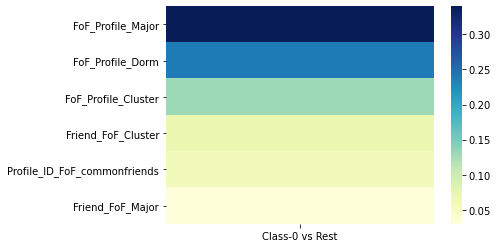

train_test_random_forest_weighted_classifier

Random Forest class-wise heatmap:

Class-0 vs Rest

(0.81, 0.81, 81.78, array([0.85, 0.77]), {'FoF_Profile_Dorm': 0.2, 'FoF_Profile_Major': 0.14, 'Friend_FoF_Dorm': 0.12, 'FoF_Profile_Cluster': 0.08, 'Friend_FoF_Cluster': 0.06, 'Profile_ID_FoF_commonfriends': 0.05})


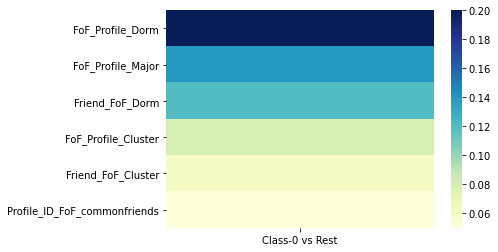

train_test_logistic_regression_weighted_classifier
Index(['Profile_ID_degree', 'Friend_degree', 'FoF_degree',
       'Profile_ID_Pagerank', 'Friend_Pagerank', 'FoF_Pagerank',
       'Profile_ID_likelihood', 'Friend_likelihood', 'FoF_likelihood',
       'Profile_ID_Friend_commonfriends', 'Profile_ID_FoF_commonfriends',
       'FoF_Friend_commonfriends', 'Profile_Sex',
       'Profile_Relationship_Status', 'Profile_Year', 'Friend_Sex',
       'Friend_Relationship_Status', 'Friend_Year', 'FoF_Sex',
       'FoF_Relationship_Status', 'FoF_Year', 'Profile_Friend_Dorm',
       'Friend_FoF_Dorm', 'FoF_Profile_Dorm', 'Profile_Friend_Major',
       'Friend_FoF_Major', 'FoF_Profile_Major', 'Profile_Friend_Cluster',
       'Friend_FoF_Cluster', 'FoF_Profile_Cluster'],
      dtype='object')

Logistic Regression class-wise heatmap:

Class-0 vs Rest

(0.77, 0.78, 78.32, array([0.82, 0.73]), {'Profile_ID_FoF_commonfriends': 5.79, 'FoF_Profile_Cluster': -3.87, 'FoF_Profile_Dorm': -2.38, 'FoF_Profile_Ma

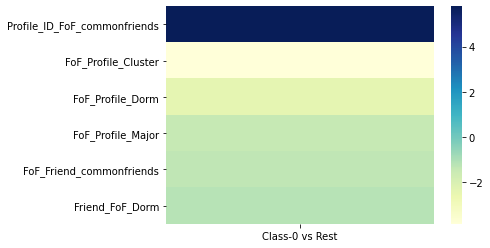

train_test_SVM_weighted_classifier

SVM class-wise heatmap:

Class-0 vs Rest

(0.78, 0.78, 78.42, array([0.82, 0.73]), {'FoF_Profile_Dorm': -0.83, 'FoF_Profile_Cluster': -0.82, 'Friend_FoF_Dorm': -0.49, 'FoF_Profile_Major': -0.47, 'Profile_ID_FoF_commonfriends': 0.42, 'FoF_Pagerank': -0.2})


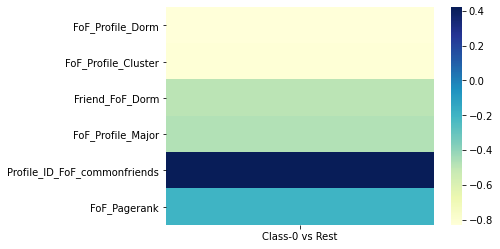

In [568]:
# Now the decision tree and random forest classifiers are not capable of producing class-wise important features.
# Logistic Regression and SVM do give out class specific coefficients as they internally carry out one-vs-rest classification 
# Construct class-specific heatmap for each classifier: check if any of the features are consistently dominant across classifiers

def important_features_class_wise(X_train, X_test, y_train, y_test, feat_list):
    # Train the decision tree and random forest classifiers in one vs rest fashion: 
    # We need to train weighted classifiers in each case, specifically in case 2 vs rest 
    
    class_0_vs_rest_train = 0.5*(y_train-1)*(y_train-2)
    class_0_vs_rest_test = 0.5*(y_test-1)*(y_test-2)
    
    class_1_vs_rest_train = (y_train)*(2-y_train)
    class_1_vs_rest_test = (y_test)*(2-y_test)
    
    class_2_vs_rest_train = 0.5*(y_train-1)*(y_train)
    class_2_vs_rest_test = 0.5*(y_test-1)*(y_test)
    
    output_dict = defaultdict(list)
    
    X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="None")

    output_dict['decision_tree_weighted_class_0'] = train_test_decision_tree_weighted_classifier(X_train, X_test, class_0_vs_rest_train, class_0_vs_rest_test, feat_list)
    output_dict['decision_tree_weighted_class_1'] = train_test_decision_tree_weighted_classifier(X_train, X_test, class_1_vs_rest_train, class_1_vs_rest_test, feat_list)
    output_dict['decision_tree_weighted_class_2'] = train_test_decision_tree_weighted_classifier(X_train, X_test, class_2_vs_rest_train, class_2_vs_rest_test, feat_list)
    
    print("\nWeighted decision tree class-wise heatmap:\n")
    print("Class-0 vs Rest\n")
    print(output_dict['decision_tree_weighted_class_0'])
    sns.heatmap(pd.DataFrame(output_dict['decision_tree_weighted_class_0'][-1],index=['Class-0 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    print("Class-1 vs Rest\n")
    print(output_dict['decision_tree_weighted_class_1'])
    sns.heatmap(pd.DataFrame(output_dict['decision_tree_weighted_class_1'][-1],index=['Class-1 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    print("Class-2 vs Rest\n")
    print(output_dict['decision_tree_weighted_class_2'])
    sns.heatmap(pd.DataFrame(output_dict['decision_tree_weighted_class_2'][-1],index=['Class-2 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    
    output_dict['random_forest_weighted_class_0'] = train_test_random_forest_weighted_classifier(X_train, X_test, class_0_vs_rest_train, class_0_vs_rest_test, feat_list)
    output_dict['random_forest_weighted_class_1'] = train_test_random_forest_weighted_classifier(X_train, X_test, class_1_vs_rest_train, class_1_vs_rest_test, feat_list)
    output_dict['random_forest_weighted_class_2'] = train_test_random_forest_weighted_classifier(X_train, X_test, class_2_vs_rest_train, class_2_vs_rest_test, feat_list)
    
    print("\nRandom Forest class-wise heatmap:\n")
    print("Class-0 vs Rest\n")
    print(output_dict['random_forest_weighted_class_0'])
    sns.heatmap(pd.DataFrame(output_dict['random_forest_weighted_class_0'][-1],index=['Class-0 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    print("Class-1 vs Rest\n")
    print(output_dict['random_forest_weighted_class_1'])
    sns.heatmap(pd.DataFrame(output_dict['random_forest_weighted_class_1'][-1],index=['Class-1 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    print("Class-2 vs Rest\n")
    print(output_dict['random_forest_weighted_class_2'])
    sns.heatmap(pd.DataFrame(output_dict['random_forest_weighted_class_2'][-1],index=['Class-2 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    output_dict['logistic_regression_weighted_class_0'] = train_test_logistic_regression_weighted_classifier(X_train, X_test, class_0_vs_rest_train, class_0_vs_rest_test, feat_list)
    output_dict['logistic_regression_weighted_class_1'] = train_test_logistic_regression_weighted_classifier(X_train, X_test, class_1_vs_rest_train, class_1_vs_rest_test, feat_list)
    output_dict['logistic_regression_weighted_class_2'] = train_test_logistic_regression_weighted_classifier(X_train, X_test, class_2_vs_rest_train, class_2_vs_rest_test, feat_list)
    
    X_train, X_test, y_train, y_test, feat_list = choose_process_features_labels(df_profiles,df_observations,df_friendships,feature_set=["Cluster","degree","Pagerank","likelihood","Sex","Relationship","Year","Dorm","Major","commonfriends"],profile_feats=1,method="std")


    print("\nLogistic Regression class-wise heatmap:\n")
    
    print("Class-0 vs Rest\n")
    print(output_dict['logistic_regression_weighted_class_0'])
    sns.heatmap(pd.DataFrame(output_dict['logistic_regression_weighted_class_0'][-1],index=['Class-0 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    print("Class-1 vs Rest\n")
    print(output_dict['logistic_regression_weighted_class_1'])
    sns.heatmap(pd.DataFrame(output_dict['logistic_regression_weighted_class_1'][-1],index=['Class-1 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    print("Class-2 vs Rest\n")
    print(output_dict['logistic_regression_weighted_class_2'])
    sns.heatmap(pd.DataFrame(output_dict['logistic_regression_weighted_class_2'][-1],index=['Class-2 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    output_dict['SVM_weighted_class_0'] = train_test_SVM_weighted_classifier(X_train, X_test, class_0_vs_rest_train, class_0_vs_rest_test, feat_list)
    output_dict['SVM_weighted_class_1'] = train_test_SVM_weighted_classifier(X_train, X_test, class_1_vs_rest_train, class_1_vs_rest_test, feat_list)
    output_dict['SVM_weighted_class_2'] = train_test_SVM_weighted_classifier(X_train, X_test, class_2_vs_rest_train, class_2_vs_rest_test, feat_list)

    print("\nSVM class-wise heatmap:\n")
    
    print("Class-0 vs Rest\n")
    print(output_dict['SVM_weighted_class_0'])
    sns.heatmap(pd.DataFrame(output_dict['SVM_weighted_class_0'][-1],index=['Class-0 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    print("Class-1 vs Rest\n")
    print(output_dict['SVM_weighted_class_1'])
    sns.heatmap(pd.DataFrame(output_dict['SVM_weighted_class_1'][-1],index=['Class-1 vs Rest']).T,cmap='YlGnBu')
    plt.show()
    
    print("Class-2 vs Rest\n")
    print(output_dict['SVM_weighted_class_2'])
    sns.heatmap(pd.DataFrame(output_dict['SVM_weighted_class_2'][-1],index=['Class-2 vs Rest']).T,cmap='YlGnBu')
    plt.show()



    


important_features_class_wise(X_train, X_test, y_train, y_test, feat_list)

### Inferences:
- Model:
 - Each person is modelled as a person in the graph, with existing friendships mapped to edge links. People are sampled from a University campus, and the corresponding real world features such as Dorm of stay, Year of study, etc. are incorporated. Some features are modelled as absolute features (which are consistent across other similar datasets), whereas some are equivalence features (features such as dorm which may have different encoding across datasets), which are comparative boolean features. 
- Labels:
 - A friend is recommended to every node, either he ignores or sends the friend request, the friend request, in turn can be accepted or rejected. 
- Data point:
 - For every data-point, we have 3 nodes under consideration. Profile-ID, Recommended Friend, Recommended FoF. This is understandable as the prediction depends upon the person whom the Friend is recommended to, and the chosen friend. Hence we have 3 tuple of features for each node.  
- Features:
 - Graph Features: 1.) Degree: Number of edges connecting every node (absolute feature). <br> 2.) Pagerank: Centrality feature. High pagerank values mean higher probability of ending up at that particular node after a long random walk (absolute feature). <br> 3.) Markov Clustering: Community detection in graphs, (inter-community edges are kept, rest diminish in strength due to iterative runs) inter-community nodes are more likely to connect as Friends. (Equivalence feature) <br> 4.) Friend Sharing likelihood: Given a particular node, how many of it's neighbors are neighbors of each other. High friend sharing likelihood indicates high inter-connectivity amongst neighbors, which may lead to higher probability of accepting the Friend request (absolute feature). <br> 5.) Common Friends: A new feature which was constructed. The idea behind it was simply: If couple of nodes have large number of common friends, they are more likely to connect together. This count is normalized with the total friends linked with both nodes. (Absolute feature). 
 - Profile features: Graph features are powerful, but insufficient as they are abstract. Profile features establish a connection with the Real world. <br> 1.) Rel. status, Sex, Year of study : Absolute features, each person can identify with these features. <br> 2.) Dorm, Major: These features may be different values/ecodings in other datasets. So they are modelled as equivalence features (every pair: Profile-ID, Friend; Friend-Friend_of_Friend; Friend_of_Friend-Profile-ID: has a boolean value for this feature based on whether the Dorm/Major value is equal/unequal for the two nodes). 
- Feature Extraction:
 - Text strings are encoded into numeric encodings using pandas dummy function. One hot encodings of categorical features did not result in improvements, hence discarded as they consume lot of memory. 
 - All the features were extracted into a single dataframe. The end user can select the features he wants to use. Loops are avoided to the extent possible and used sparingly. 
 - Standardization and Normalization were tested. Standardization and Normalization. These transformations have no effect on decision tree & random forest outcomes. Hence no transformations used for decision tree features. 
 - Consequentially, standardization resulted in slightly better performance, but considerably lower running time for logistic regression and SVM. This may be due to very high feature dimension (~30). And standardization bring points closer together and reducing sparsity. 
- Trained Models: 
  - Decision Tree, Random Forest, Logistic Regression, SVM. It was observed that the dataset is significantly biased against class-2 (Friend Request sent by base user and Friend request accepted by Friend of Friend). Hence weighted classifiers were tested against the dataset. 
  - Gauging metrics were f1-score (macro and weighted) and accuracy.
  - Hyperparameter tuning: Via Grid Search. 5-fold CV. Training set was replicated 5 times and shuffled. Each of these shuffles was split into training and validation sets. Best hyperparameters were chosen according to f1-score metric on the validation set. Model was re-trained on entire training data and tested on unseen test data to determine model performance.
  - Top features affecting decision making were stored for further insights. 
 

#### Overall Classification:
 - Results:
 
|                                |   f1_score_macro |   f1_score_weighted |   accuracy |   f1_score_class-0 |   f1_score_class-1 |   f1_score_class-2 |
|:-------------------------------|-----------------:|--------------------:|-----------:|-------------------:|-------------------:|-------------------:|
| decision_tree_unweighted       |             0.85 |                0.82 |      82.38 |               0.78 |               0.85 |               0.91 |
| decision_tree_weighted         |             0.87 |                0.81 |      81.88 |               0.77 |               0.85 |               1    |
| random_forest_unweighted       |             0.83 |                0.82 |      82.18 |               0.76 |               0.86 |               0.87 |
| random_forest_weighted         |             0.84 |                0.82 |      82.48 |               0.77 |               0.86 |               0.9  |
| logistic_regression_unweighted |             0.84 |                0.79 |      79.7  |               0.72 |               0.84 |               0.97 |
| logistic_regression_weighted   |             0.85 |                0.8  |      80.3  |               0.75 |               0.84 |               0.97 |
| SVM_unweighted                 |             0.87 |                0.81 |      81.39 |               0.76 |               0.85 |               1    |
| SVM_weighted                   |             0.87 |                0.81 |      81.09 |               0.76 |               0.84 |               1    |

  - Decision tree performs better than random forest. This maybe because each tree in the Forest relies on a subset of features and bootstrap samples. Surprisingly SVM with linear kernel performed as well as Decision Tree classifier, especially on the imbalanced class.
  - Outcome of weighted classifiers was better on imbalanced class (class-2). 

#### Class-wise Classification:

 - Experiment: For each classifier, we explicitly try to implement OvR (One vs Rest) classification. Due to disparity in the number of samples for each class, we train weighted classifiers. Top features (according to feature coefficients) for each classifier are extracted for further analysis. 
 - Results: Prediction problem involves predicting whether the base user sends a friend request or ignores the recommended friend.  The models could be separated into two parts: Decision Tree models (non-linear, multiple splits of the feature spaces via simple linear decision boundaries), and linear models like logistic regression and SVM (linear kernel used in SVM). Decision Tree splits are aligned along the axis, as they work with one feature at a time. Interpreting, recognizing important features (according to coefficients) can be quite challenging. 
  - Class-0 vs rest: Data points belonging to class-0 convey ignorance towards the recommendation. A weighted Random forest classifier performed the best among the lot. In Class-0 vs rest classification, Class-0 data points are labeled as 1 and rest of the classes are labeled as 0. Similarly Class-1 vs rest and Class-2 vs rest models are trained. 
  - Weighted Decision Tree: From the first sub-tree, one can conclude that if the recommended FoF (friend of friend) doesn't belong to the same Major, Dorm and Cluster then the recommendation is going to be ignored by the base user. This is quite intuitive, usually unfamiliar people rarely connect (unless they are extreme extroverts and want to expand their network). Even if the base user and FoF have a different major, if they belong to the same Dorm and Cluster and have a decent number of common friends, then the base user is likely send out a Friend request. Many such intuitive insights can be drawn from the decision tree diagram, which can help our simple recommendation engine. Another interesting point to note is that of profiles which are having rel status as 3 and Sex as 1 are likely to send friend requests even if the Profile and FoF clusters differ (with the same major for both, which might mean a good acquaintance) .   
  - Random Forest: Random Forest is an ensemble of Decision Trees, each decision tree is trained upon a subset of features and bootstrap samples are provided to it. Most important features are averaged out of all the trees. Hence the random forest classifier is not as comprehensible as the Decision Tree. Nevertheless, we can look at the dominating features used in RF training.  Propitiously, Dorm, major, cluster are similar to those in Decision Tree. Thus people who get acquainted by staying in the same dorm/studying in the same major, or belonging to the same social group (via different clubs, social activities) have propensity towards friendships in the social graph. 
  - Linear Classifiers like logistic regression and SVM assign weights to coefficients: Apart from the profile and graph features delineated above, our Common_Friends feature finds it's way to the set of important features. 
 
#### Conclusion:
 - The main aim of this project was to help the recommendation engine make better decisions. The underlying idea was not to develop a rigorous model for the same, but to understand and fine-tune (improve) the existing simpler model. Given, a person A, one of his friends (say B) is randomly selected. Then a friend of B (say C) is randomly selected and recommended as a friend to A.  
 - The original problem at hand can be modelled as a classic Graph Edge prediction problem (link prediction). Every node has a set of graph features and some real world features. With an existing graph split into Training and Test sets, link prediction could be carried out. Both positive and negative links could be constructed with the outcomes available for the given recommendations.  
 - In this project the existing Graph is taken in as a whole (based on existing friendship linkages). Graph features are derived from it. Real world profile features aid the Graph features. Then decision models are trained to better understand the success/failure of the simple recommednation algorithm.  
 - Improvements to the recommendation procedure: Useless (friend request not sent or friend request not accepted) recommendations prove to be a nuisance to an user and also waste the recommendation efforts. A decision tree diagram (or a text tree), can help us identify the conditions under which such cases arise. Also for models such as logistic regression and SVM, most important features can be correlated with the label output. We suggest a simple modification to the original friend recommendation algorithm:
   - The available network graph is quite sparse: (~88,000 edges, overall possible (4039).(4038)/2 = ~8.2 million), which means that there is enough scope to establish dense connections. 
   - While choosing a friend, he/she should be an acquaintance of the base user. This can be ensured by checking the friend's habitat proximity (dorm), discipline of study (year and major), the existing cluster of friend and the base user. Similar checks can be carried out for FoF. 
   - More interesting choices could be recommended. For example males who are not in a relationship could be recommended females who are not in a relationship, irrespective of major,dorm,cluster and other profile attributes. 
   - People with lot of friend sharings or having a lot of common friends have a higher likelihood of sending and accepting friend requests. Same might be true for people with high number of friends (degree) and higher pagerank values (node centrality). These recommendations could be useful to construct a denser graph. 
   
